The first step involves importing essential Python libraries like:

NumPy and Pandas for data manipulation

Matplotlib or Seaborn for visualizing data

Torch and Torchvision for building and training CNN models

There may also be specific data transformation and normalization functions, often in torchvision.transforms.

In [1]:
import os
import torch
from torch import nn
from torchvision.datasets import MNIST
from torch.utils.data import DataLoader, ConcatDataset, SubsetRandomSampler
from torchvision import transforms, datasets

from sklearn.model_selection import KFold
import matplotlib.pyplot as plt

Loading and Preparing the Dataset:

Typically, the tutorial uses a pre-existing dataset like MNIST or CIFAR-10, which is available in torchvision.datasets.

The data is split into training and test sets.

Data preprocessing: This step involves normalizing images to make the network training more efficient and often includes resizing, scaling, and converting images to tensors.

Cross-Validation Setup

Cross-validation is a method to improve the reliability of model evaluation. Here's how it works in the tutorial:

K-Fold Cross-Validation: The data is split into k subsets or "folds." Each fold is used once as a validation set while the remaining k-1 folds form the training set. This is implemented using PyTorch’s data utilities or sklearn.model_selection.KFold.

Purpose: Cross-validation ensures that the model's performance is consistent and not dependent on a single train-test split.

In [2]:
# Function to display examples from a dataset
def show_examples(dataset, num_examples=5):
    fig, axes = plt.subplots(1, num_examples, figsize=(12, 3))

    for i in range(num_examples):
        # Get a random example
        index = torch.randint(len(dataset), size=(1,)).item()
        image, label = dataset[index]

        # Display the image
        axes[i].imshow(image.squeeze(), cmap='gray')
        axes[i].set_title(f"Label: {label}")
        axes[i].axis('off')

    plt.show()

Failed to download (trying next):
<urlopen error [SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: certificate has expired (_ssl.c:1007)>



100%|██████████| 9912422/9912422 [00:11<00:00, 886627.49it/s] 


Extracting /home/diya/Projects/DLSC-projects/notebooks/MNIST/raw/train-images-idx3-ubyte.gz to /home/diya/Projects/DLSC-projects/notebooks/MNIST/raw

Failed to download (trying next):
<urlopen error [SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: certificate has expired (_ssl.c:1007)>



100%|██████████| 28881/28881 [00:00<00:00, 136069.45it/s]


Extracting /home/diya/Projects/DLSC-projects/notebooks/MNIST/raw/train-labels-idx1-ubyte.gz to /home/diya/Projects/DLSC-projects/notebooks/MNIST/raw

Failed to download (trying next):
<urlopen error [SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: certificate has expired (_ssl.c:1007)>



100%|██████████| 1648877/1648877 [00:01<00:00, 1128469.60it/s]


Extracting /home/diya/Projects/DLSC-projects/notebooks/MNIST/raw/t10k-images-idx3-ubyte.gz to /home/diya/Projects/DLSC-projects/notebooks/MNIST/raw

Failed to download (trying next):
<urlopen error [SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: certificate has expired (_ssl.c:1007)>



100%|██████████| 4542/4542 [00:00<00:00, 8116970.08it/s]

Extracting /home/diya/Projects/DLSC-projects/notebooks/MNIST/raw/t10k-labels-idx1-ubyte.gz to /home/diya/Projects/DLSC-projects/notebooks/MNIST/raw

Examples from the Training Set:


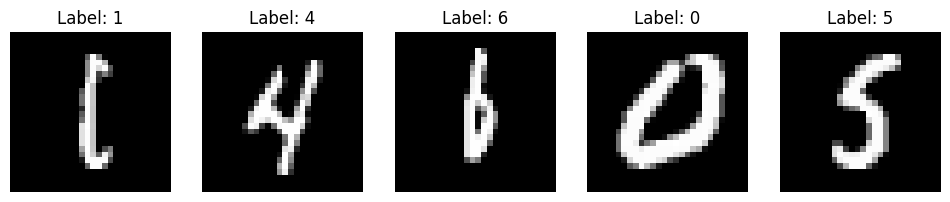


Examples from the Test Set:


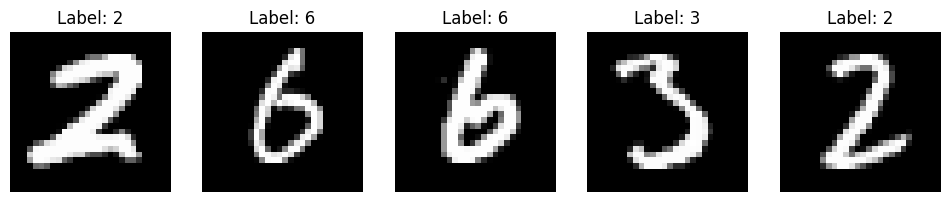

In [3]:
# Define the MNIST datasets.
dataset_train_part = MNIST(
    os.getcwd(), download=True, transform=transforms.ToTensor(), train=True)
dataset_test_part = MNIST(
    os.getcwd(), download=True, transform=transforms.ToTensor(), train=False)


# Display examples from the training set
print("Examples from the Training Set:")
show_examples(dataset_train_part)

# Display examples from the test set
print("\nExamples from the Test Set:")
show_examples(dataset_test_part)

Defining the CNN Architecture

The tutorial introduces a basic CNN model, which generally includes:

Convolutional Layers: Extract spatial features from images. Layers often start with fewer filters and gradually increase in number.

Activation Functions: Usually ReLU, to introduce non-linearity.

Pooling Layers: Often MaxPooling, to reduce dimensionality and computational load.

Fully Connected Layers: These come after convolutional layers to learn high-level representations for classification.

Output Layer: For classification, it’s often a Softmax or Sigmoid layer to give a probability distribution over classes.

In [4]:
def reset_weights(m):
  '''
    Try resetting model weights to avoid
    weight leakage.
  '''
  for layer in m.children():
   if hasattr(layer, 'reset_parameters'):
    print(f'Reset trainable parameters of layer = {layer}')
    layer.reset_parameters()

class SimpleConvNet(nn.Module):
  '''
    Simple Convolutional Neural Network
  '''
  def __init__(self):
    super().__init__()
    self.layers = nn.Sequential(
      nn.Conv2d(1, 10, kernel_size=3),
      nn.ReLU(),
      nn.Flatten(),
      nn.Linear(26 * 26 * 10, 50),
      nn.ReLU(),
      nn.Linear(50, 20),
      nn.ReLU(),
      nn.Linear(20, 10)
    )


  def forward(self, x):
    '''Forward pass'''
    return self.layers(x)

Training the Model

Loss Function: Cross-Entropy Loss is common for classification tasks.

Optimizer: Stochastic Gradient Descent (SGD) or Adam optimizes the model parameters by minimizing the loss.

The training loop iterates through each batch of the training data, calculating the forward and backward passes, and updating the weights.

In [5]:
def train_model(network, trainloader, optimizer, loss_function, num_epochs):
    # Function to perform the training.
    for epoch in range(num_epochs):
        print(f'Starting epoch {epoch + 1}')
        current_loss = 0.0

        for i, data in enumerate(trainloader, 0):
            inputs, targets = data
            optimizer.zero_grad()
            outputs = network(inputs)
            loss = loss_function(outputs, targets)
            loss.backward()
            optimizer.step()
            current_loss += loss.item()

            if i % 500 == 499:
                print(
                    'Loss after mini-batch %5d: %.3f' %
                     (i + 1, current_loss / 500)
                )
                current_loss = 0.0

Testing and Results

After training and validation, the model is finally evaluated on the test set to report its performance.

The tutorial typically visualizes results, like plotting a confusion matrix or showing sample predictions.

In [6]:
def test_model(network, testloader):
   # Function to test the model on the test set for a fold
    correct, total = 0, 0

    with torch.no_grad():
        for i, data in enumerate(testloader, 0):
            inputs, targets = data
            outputs = network(inputs)
            _, predicted = torch.max(outputs.data, 1)
            total += targets.size(0)
            correct += (predicted == targets).sum().item()

    accuracy = 100.0 * correct / total
    print(f'Accuracy: {accuracy:.2f}%')
    return accuracy


Validation Process

Evaluation Mode: The model switches to evaluation mode to freeze parameters like dropout, which should be inactive during validation.

Metric Calculation: During validation, the model calculates accuracy or other metrics to assess performance on unseen data.

Cross-Validation Cycle: This process repeats for each fold in cross-validation, resulting in an averaged metric score that represents the model’s overall performance.

In [7]:
def k_fold_cross_validation(k_folds, num_epochs, loss_function):
    # Function to perform k-fold cross-validation
    results = {}
    dataset = ConcatDataset([dataset_train_part, dataset_test_part])
    kfold = KFold(n_splits=k_folds, shuffle=True)

    for fold, (train_ids, test_ids) in enumerate(kfold.split(dataset)):
        print(f'FOLD {fold}')
        print('--------------------------------')

        train_subsampler = SubsetRandomSampler(train_ids)
        test_subsampler = SubsetRandomSampler(test_ids)

        trainloader = DataLoader(
            dataset, batch_size=10, sampler=train_subsampler)
        testloader = DataLoader(
            dataset, batch_size=10, sampler=test_subsampler)

        network = SimpleConvNet()
        network.apply(reset_weights)
        optimizer = torch.optim.Adam(network.parameters(), lr=1e-4)

        train_model(network, trainloader, optimizer, loss_function, num_epochs)

        print('Training process has finished. Saving trained model.')
        print('Starting testing')

        save_path = f'./model-fold-{fold}.pth'
        torch.save(network.state_dict(), save_path)

        accuracy = test_model(network, testloader)
        results[fold] = accuracy
        print('--------------------------------')

    return results


In [8]:
# Function to print k-fold cross-validation results
def print_results(results):
    print(f'K-FOLD CROSS VALIDATION RESULTS FOR {len(results)} FOLDS')
    print('--------------------------------')

    total_accuracy = sum(results.values())
    average_accuracy = total_accuracy / len(results)

    for key, value in results.items():
        print(f'Fold {key}: {value:.2f}%')

    print(f'Average: {average_accuracy:.2f}%')

In [9]:
# Main function
def main():
    k_folds = 5
    num_epochs = 1
    loss_function = nn.CrossEntropyLoss()

    results = k_fold_cross_validation(k_folds, num_epochs, loss_function)
    print_results(results)

In [10]:
main()

FOLD 0
--------------------------------
Reset trainable parameters of layer = Conv2d(1, 10, kernel_size=(3, 3), stride=(1, 1))
Reset trainable parameters of layer = Linear(in_features=6760, out_features=50, bias=True)
Reset trainable parameters of layer = Linear(in_features=50, out_features=20, bias=True)
Reset trainable parameters of layer = Linear(in_features=20, out_features=10, bias=True)
Starting epoch 1
Loss after mini-batch   500: 1.614
Loss after mini-batch  1000: 0.715
Loss after mini-batch  1500: 0.516
Loss after mini-batch  2000: 0.445
Loss after mini-batch  2500: 0.416
Loss after mini-batch  3000: 0.382
Loss after mini-batch  3500: 0.367
Loss after mini-batch  4000: 0.315
Loss after mini-batch  4500: 0.312
Loss after mini-batch  5000: 0.309
Loss after mini-batch  5500: 0.298
Training process has finished. Saving trained model.
Starting testing
Accuracy: 92.02%
--------------------------------
FOLD 1
--------------------------------
Reset trainable parameters of layer = Conv

The purpose of using cross-validation is to ensure robust model evaluation.

CNNs excel at image tasks due to their hierarchical feature extraction.

Hands-on experimentation with layers, loss functions, and optimizers gives insight into how CNN architectures work in practice.